# Script for Parameter inference using SNe data - Inference with various models, analytical marginalization, etc.

In [490]:
import numpy as np
import pandas as pd
import emcee
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid, trapezoid
from scipy.interpolate import interp1d
from chainconsumer import Chain, ChainConsumer, ChainConfig, Truth
from IPython.display import display, Math


## Cosmological Models

In [491]:
def d_L(h, z, o_m, o_l, o_k=None, **kwargs):
    """Calculate Luminosity distance for given cosmological parameters.

    Parameters
    ----------
    h : int or np.array
        hubble parameter 
    z : np.array
        redshift 
    o_m : int
        Omega_m 
    o_l : int
        Omega_Lambda
    o_k : int
        Omega_k
    w : int (optional)
        DE EOS parameter 
        
    Returns
    -------
    d_L : np.array
        Luminosity distance
    """

    o_r = 9.e-5
    if o_k is None:
        o_k = 1 - o_m - o_l - o_r
    elif o_k == 0:
        o_l = 1 - o_m - o_r

    w = kwargs.get('w', None)

    # Hubble distance
    d_H = 2997.92458/h
    
    # Comoving Distance
    if w == None:
        d_C = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4  )
        d_C = cumulative_trapezoid(d_C(o_m, o_l, o_k), z, initial=0)
    else:
        d_C = lambda omega_m, omega_lambda, omega_k, w, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda * (1 + z)**(3 * (1 + w)) + omega_r * (1+z)**4)
        d_C = cumulative_trapezoid(d_C(o_m, o_l, o_k, w), z, initial=0)
    d_C[np.isnan(d_C)] = 0
    
    # Transverse comoving distance:
    omega_k = o_k
    if omega_k > 0:
        d_M = d_H * (1/np.sqrt(omega_k)) * np.sinh((np.sqrt(omega_k) * d_C) / d_H) 
    if omega_k == 0:
        d_M = d_C
    if omega_k < 0:
        d_M = d_H * (1/np.sqrt(-omega_k)) * np.sin((np.sqrt(-omega_k) * d_C) / d_H) 

    # Luminosity Distance
    d_L = (1 + z) * d_M
    return d_L

def distance_modulus(h, z, omega_m, omega_l, omega_k=None, **kwargs):
    """ Calculate distance modulus """
    w = kwargs.get('w', None)
    dl = d_L(h, z, omega_m, omega_l, omega_k, w=w)
    dis_mod = 5 * np.log10(dl) + 25
    return dis_mod

def chi_square(y_model, y, yerr):
    """ Calculate chi-square for individual data"""
    p = (y - y_model)**2/(yerr)**2
    return p 

def cov_chi_square(y_model, y, inv_cov):
    """ Calculate chi-square using covariance matrix"""
    diff = y - y_model
    chi2 = np.dot(diff.T , np.dot(inv_cov, diff))
    return chi2

## Dataset

In [492]:
# SNe Data
df = pd.read_csv("SCPUnion2_mu_vs_z.txt", sep="\t", header=None, names=["object_name", "redshift", "magnitude", "error_magnitude"], skiprows=5)

cov_mat = pd.read_csv("SCPUnion2_covmat_sys.txt", sep="\t", header=None)
del cov_mat[cov_mat.columns[-1]]
#print(cov_mat.to_numpy().shape)
#print(cov_mat.to_numpy())
#print(cov_mat)
cov_mat = cov_mat.to_numpy()

try:
    inv_cov = np.linalg.inv(cov_mat)
except np.linalg.LinAlgError:
    raise ValueError("Covariance matrix is singular or not invertible")

df["magnitude"].to_numpy().shape

(557,)

## EMCEE Sampling

### $\Omega_M$ vs $\Omega_\Lambda$

In [319]:
# Define the log prior
def log_prior(theta):
    omega_m, omega_l = theta
    if 0.0 < omega_m < 0.5 and 0.4 < omega_l < 1.0:  # Prior for sigma must be positive
        return 0.0  # Flat prior
    return -np.inf  # Reject invalid sigma values

# Define the log likelihood
def log_likelihood(theta, data):
    omega_m, omega_l = theta
    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    mag_err = data['error_magnitude'].to_numpy()
    h = 0.7
    z = np.linspace(0, 2, 1000)
    
    model1 = distance_modulus(h, z, omega_m, omega_l)
    func_model1 = interp1d(z, model1)
    model2 = func_model1(z_array)
    chi2 = chi_square(model2, mag_array, mag_err)
    chi2 = np.sum(chi2)
    return -chi2/2 

def log_likelihood_cov(theta, data, inv_cov):
    # Unpack parameters
    omega_m, omega_l = theta
    
    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    #cov_mat = cov_mat.to_numpy()
    #print('cov shape', cov_mat.shape)
    #cov_mat[np.isnan(cov_mat)] = 0

    h = 0.7
    z = np.linspace(0, 2, 1000)
    
    model1 = distance_modulus(h, z, omega_m, omega_l)
    func_model1 = interp1d(z, model1)
    model2 = func_model1(z_array)
    chi2 = cov_chi_square(model2, mag_array, inv_cov)
    #chi2[np.isnan(chi2)] = np.inf

    return -chi2/2

# Define the log posterior (log probability)
def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, data)

In [108]:
def gelman_rubin(chains):
    """
    Calculate the Gelman-Rubin statistic (R_hat) for MCMC chains.
    
    Parameters:
    -----------
    chains : numpy array of shape (n_chains, n_samples, n_params)
        MCMC chains. Should be an array where each row represents a chain, 
        and each column represents samples for a parameter.
    
    Returns:
    --------
    R_hat : numpy array of shape (n_params,)
        Gelman-Rubin R-hat statistic for each parameter.
    """
    
    # Number of chains, number of samples, and number of parameters
    m, n = chains.shape
    
    # Step 1: Mean of each chain for each parameter (shape: m x p)
    chain_means = np.mean(chains, axis=1)
    
    # Step 2: Variance within each chain (shape: m x p)
    chain_vars = np.var(chains, axis=1, ddof=1)
    
    # Step 3: Overall mean of the chains (shape: p,)
    overall_mean = np.mean(chain_means, axis=0)
    
    # Step 4: Between-chain variance (B) (shape: p,)
    B = n * np.var(chain_means, axis=0, ddof=1)
    
    # Step 5: Within-chain variance (W) (shape: p,)
    W = np.mean(chain_vars, axis=0)
    
    # Step 6: Estimate of the variance of the target distribution
    var_hat = (n - 1) / n * W + (1 / n) * B
    
    # Step 7: Calculate R_hat (shape: p,)
    R_hat = np.sqrt(var_hat / W)
    
    return R_hat

In [348]:
data = df

# Number of dimensions (h, omega_m, omega_l)
ndim = 2

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 6

# Initial positions of the walkers (random guesses)
initial_guesses = np.random.rand(nwalkers, ndim)

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[data])

In [349]:
# Run the MCMC for 500 steps
nsteps = 100000
sampler.run_mcmc(initial_guesses, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_16790/200815787.py:62: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
  0%|          | 0/100000 [00:00<?, ?it/s]/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_16790/200815787.py:38: RuntimeWarning: invalid value encountered in sqrt
  d_C = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4  )
100%|██████████| 100000/100000 [02:09<00:00, 772.85it/s]


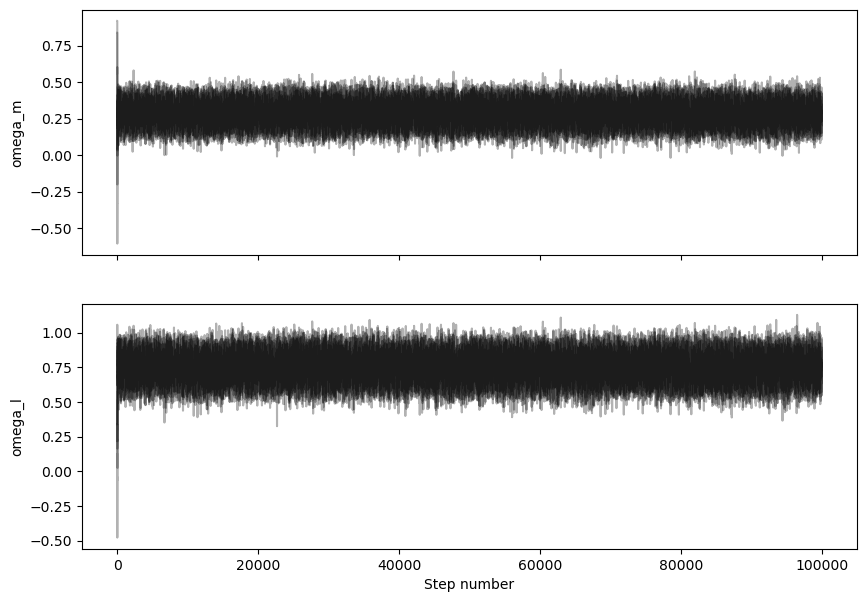

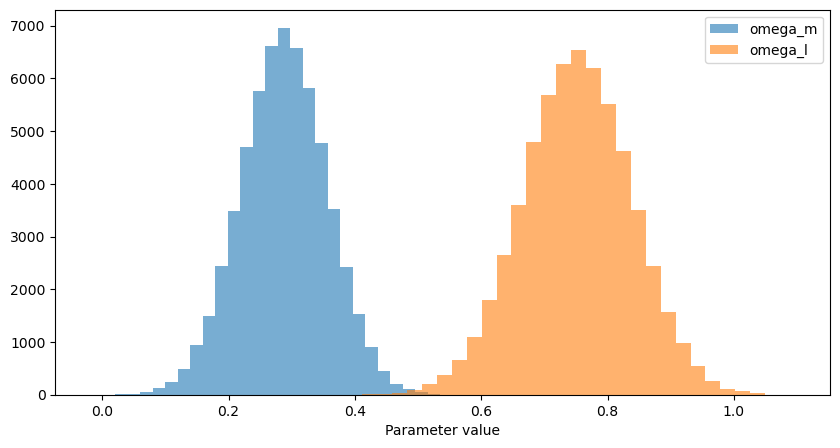

In [350]:
# Plot the walker chains for each parameter
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = [ "omega_m", "omega_l"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.show()

# Flatten the chain (remove burn-in and combine walkers)
flat_samples = sampler.get_chain(discard=500, thin=10, flat=True)

# Plot histograms of the posterior samples
plt.figure(figsize=(10,5))
plt.hist(flat_samples[:, 0], bins=30, alpha=0.6, label="omega_m")
plt.hist(flat_samples[:, 1], bins=30, alpha=0.6, label="omega_l")
plt.xlabel("Parameter value")
plt.legend()
plt.show()

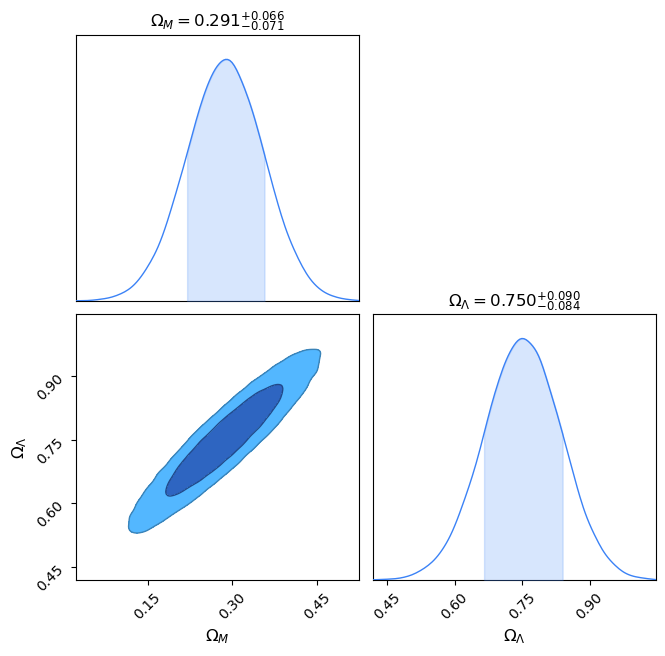

In [351]:
df1 = pd.DataFrame(flat_samples, columns = ['$\Omega_M$', '$\Omega_\Lambda$'])
#print(df1)
c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="An Example Contour"))
#c.add_chain(flat_samples)
fig = c.plotter.plot()

In [352]:
# Calculate the Gelman-Rubin R-hat statistic
r_hat = gelman_rubin(flat_samples)

# Print the R-hat statistic for each parameter
print("Gelman-Rubin R-hat values for each parameter:", r_hat)

Gelman-Rubin R-hat values for each parameter: 0.7440883254340301


In [353]:
### SAVE RESULTS ####

df1.to_csv("omega_m_omega_l-curved_universe_EMCEE.csv", index=False)

#### One with covariance matrix

In [383]:
data = df

# Number of dimensions (h, omega_m, omega_l)
ndim = 2

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 6

# Initial positions of the walkers (random guesses)
#initial_guesses = np.random.rand(nwalkers, ndim)
initial_omega_m = np.random.uniform(0.25, 0.35, nwalkers)  # Omega_m
initial_omega_l = np.random.uniform(0.65, 0.75, nwalkers)      # w

# Combine initial positions into one array (for 3 parameters)
pos = np.array([ initial_omega_m, initial_omega_l]).T  # Shape (nwalkers, 3)
print(pos)

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_cov, args=[data, inv_cov])

[[0.30915342 0.68412883]
 [0.29203541 0.68842735]
 [0.34054927 0.74297389]
 [0.28718896 0.71128065]
 [0.29304459 0.71943872]
 [0.2805948  0.69731204]]


In [384]:
# Run the MCMC for 500 steps
nsteps = 100000
sampler.run_mcmc(initial_guesses, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_16790/1743800503.py:62: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
  0%|          | 0/100000 [00:00<?, ?it/s]

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_16790/1743800503.py:38: RuntimeWarning: invalid value encountered in sqrt
  d_C = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4  )
100%|██████████| 100000/100000 [07:35<00:00, 219.41it/s]


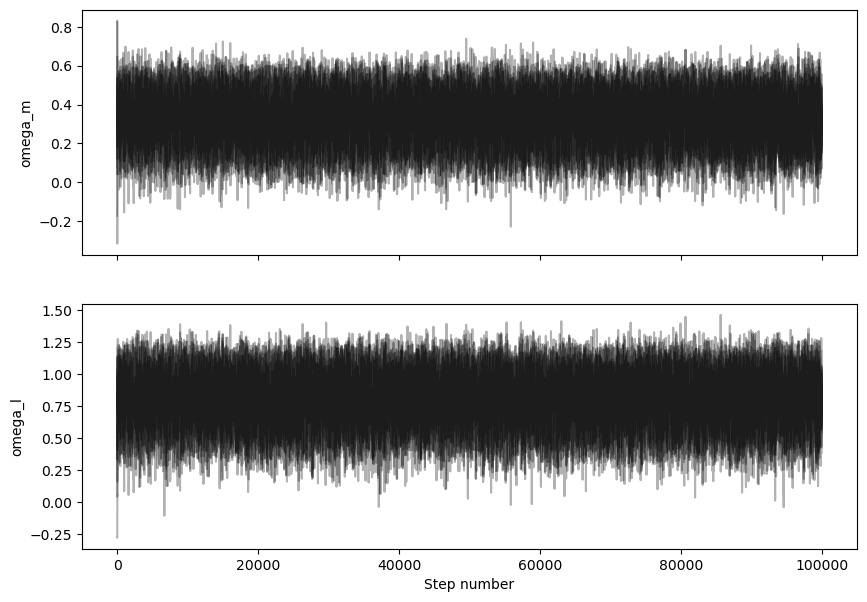

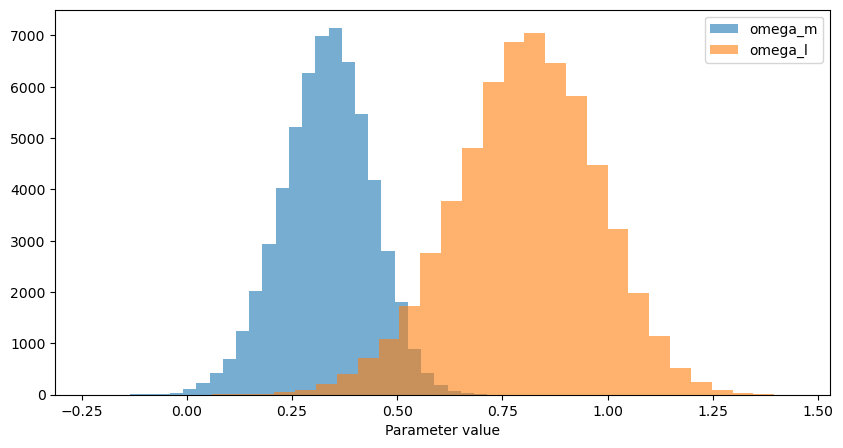

In [385]:
# Plot the walker chains for each parameter
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = [ "omega_m", "omega_l"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.show()

# Flatten the chain (remove burn-in and combine walkers)
flat_samples = sampler.get_chain(discard=500, thin=10, flat=True)

# Plot histograms of the posterior samples
plt.figure(figsize=(10,5))
plt.hist(flat_samples[:, 0], bins=30, alpha=0.6, label="omega_m")
plt.hist(flat_samples[:, 1], bins=30, alpha=0.6, label="omega_l")
plt.xlabel("Parameter value")
plt.legend()
plt.show()

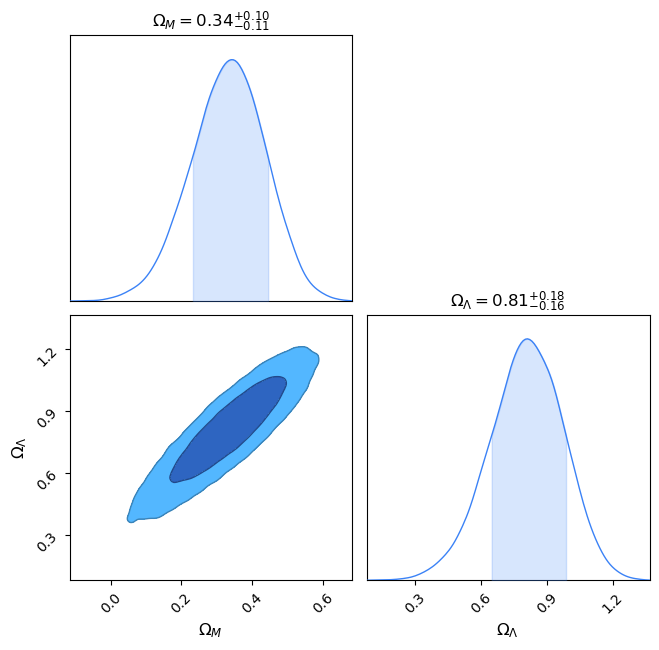

In [386]:
df1 = pd.DataFrame(flat_samples, columns = ['$\Omega_M$', '$\Omega_\Lambda$'])
#print(df1)
c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="An Example Contour"))
#c.add_chain(flat_samples)
fig = c.plotter.plot()

In [387]:
# Calculate the Gelman-Rubin R-hat statistic
r_hat = gelman_rubin(flat_samples)

# Print the R-hat statistic for each parameter
print("Gelman-Rubin R-hat values for each parameter:", r_hat)

Gelman-Rubin R-hat values for each parameter: 0.8089766748779802


In [388]:
### SAVE RESULTS ####

df1.to_csv("omega_m_omega_l-curved_universe_EMCEE_covariance.csv", index=False)

#### Comparison

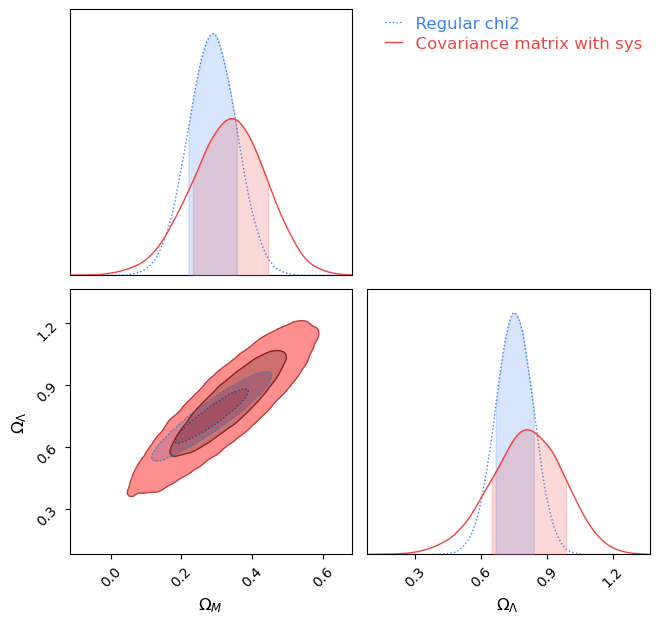

In [389]:
df1 = pd.read_csv("omega_m_omega_l-curved_universe_EMCEE.csv") 
df2 = pd.read_csv("omega_m_omega_l-curved_universe_EMCEE_covariance.csv") 

c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="Regular chi2", color = "blue", linestyle=":"))
c.add_chain(Chain(samples=df2, name="Covariance matrix with sys", color = "red"))
fig = c.plotter.plot()

### $\Omega_M$ using marginalized chi square (without covariance matrix) (Flat $\Lambda$ CDM)

In [470]:
def log_prior(theta):
    omega_m = theta
    if 0.02 < omega_m < 0.535:
        return 0
    return -np.inf  # Reject invalid sigma values

def marginalized_log_likelihood(theta, data):
    """ Flat universe """
    omega_m = theta

    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    mag_err = data['error_magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)
    #h = np.linspace(0.68, 0.72, 1000)


    # Marginalize over H0
    
    om_k = 0
    om_r = 9.e-5
    om_l = 1 - omega_m - om_r - om_k

    #d_H = 2997.92458/h
    #A = 5 * np.log10(d_H)

    int1 = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : 1/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4)
    int1 = cumulative_trapezoid(int1(omega_m, om_l, om_k), z, initial=0)
    func = interp1d(z, int1)
    int1 = func(z_array)

    B = (5 * np.log10((1 + z_array) * int1)) + 25

    f1 = 0.5 * np.sum(1 / (mag_err ** 2))
    f2 = np.sum((B - mag_array) / (mag_err ** 2))
    f3 = 0.5 * np.sum(((B - mag_array) ** 2 )/ (mag_err ** 2))

    chi2_marginalized = (2 * f3) - (f2**2 / (2 * f1))
    
    #integrand = lambda f1, f2, f3, A: np.exp(f3 + (A * f2) + (f1 * A * A))

    marginalized_likelihood = np.exp(-0.5 * chi2_marginalized)#trapezoid(integrand(f1, f2, f3, A), h)    
    return np.log(marginalized_likelihood)

# Define the log posterior (log probability)
def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + marginalized_log_likelihood(theta, data)


data = df

# Number of dimensions (h, omega_m, omega_l, w)
ndim = 1

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 3

# Initial positions of the walkers (random guesses)
#initial_guesses = np.random.uniform(low=0.1, high=1, size=(nwalkers, ndim))
initial_omega_m = np.random.uniform(0.25, 0.35, nwalkers)  # Omega_m

# Combine initial positions into one array (for 3 parameters)
pos = np.array([ initial_omega_m]).T  # Shape (nwalkers, 3)
print(pos)
# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])

[[0.2805956 ]
 [0.28031103]
 [0.30139861]]


In [471]:
# Run the MCMC 
nsteps = 100000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

100%|██████████| 100000/100000 [01:15<00:00, 1319.65it/s]


Results from paper: Without systematics


<IPython.core.display.Math object>

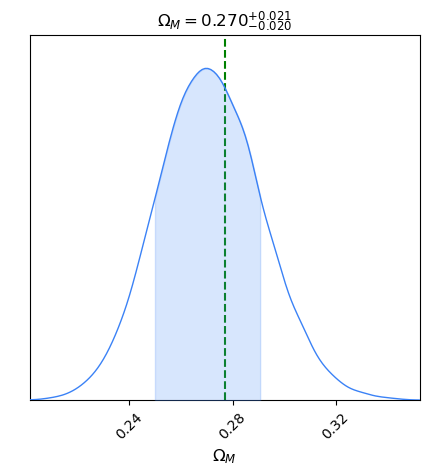

In [474]:
# Flatten the chain (remove burn-in and combine walkers)
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

df3 = pd.DataFrame(flat_samples, columns = ['$\Omega_M$'])

#print(df1)
c = ChainConsumer()
c.add_chain(Chain(samples=df3, name="An Example Contour"))
#c.add_chain(flat_samples)
fig = c.plotter.plot()


### Results from paper
omega_m_central = 0.277
omega_m_error_left = 0.021
omega_m_error_right = 0.022
plt.axvline(x=omega_m_central, color="green", linestyle="--", label="Results from paper")
#plt.legend()
print("Results from paper: Without systematics")
display(Math(r'\Omega_M = 0.295^{{+0.040}}_{{-0.043}}  ') )


### $\Omega_M$ using marginalized covariance matrix chi square 

In [475]:
# Define the log prior
def log_prior(theta):
    omega_m = theta
    if 0.02 < omega_m < 0.535:  
        return 0.0  # Flat prior
    return -np.inf  # Reject invalid sigma values

def marginalized_log_likelihood_covariance(theta, data, inv_cov):
    """ Flat universe """
    omega_m = theta

    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    n = mag_array.size
    #mag_err = data['error_magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)
    #h = np.linspace(0.65, 0.75, n) ### prior

    # Marginalize over H0
    
    om_k = 0
    om_r = 9.e-5
    om_l = 1 - omega_m - om_r - om_k

    #d_H = 2997.92458/h
    #A = - 5 * np.log10(h)

    int1 = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : 1/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4)
    int1 = cumulative_trapezoid(int1(omega_m, om_l, om_k), z, initial=0)
    func = interp1d(z, int1)
    int1 = func(z_array)

    B = (5 * np.log10((1 + z_array) * int1)) + 25 + (5 * np.log10(2997.92458))

    one = np.ones(n)
    f1 = np.dot(one.T, np.dot(inv_cov, one))
    f2 = - 2 * np.dot(one.T, np.dot(inv_cov, (mag_array - B)))
    f3 = np.dot((mag_array - B).T, np.dot(inv_cov, mag_array - B))

    chi2_marginalized = f3 - (f2**2 / (4 * f1))

    #integrand = lambda f1, f2, f3, A: np.exp(-0.5 * ((f1 * A * A) + (f2 * A) + f3))

    #marginalized_likelihood = trapezoid(integrand(f1, f2, f3, A), h)   
    marginalized_likelihood = np.exp(- 0.5 * chi2_marginalized)

    #marginalized_likelihood = np.sqrt((2*np.pi)/f1) * np.exp((f2**2 / (2*f1)) - (f3/2)) # this is integrated wrt A not h
    return np.log(marginalized_likelihood)

# Define the log posterior (log probability)
def log_posterior(theta, data, inv_cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + marginalized_log_likelihood_covariance(theta, data, inv_cov)


In [476]:
data = df

# Number of dimensions (h, omega_m, omega_l)
ndim = 1

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 3

# Initial positions of the walkers (random guesses)
initial_omega_m = np.random.uniform(0.25, 0.35, nwalkers)  # Omega_m

# Combine initial positions into one array (for 3 parameters)
pos = np.array([ initial_omega_m]).T  # Shape (nwalkers, 1)
print(pos)
# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data, inv_cov])

[[0.28654687]
 [0.32489108]
 [0.29497032]]


In [477]:
# Run the MCMC for 500 steps
nsteps = 100000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [10:57<00:00, 152.06it/s]


In [478]:
# Flatten the chain (remove burn-in and combine walkers)
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
flat_samples

array([[0.18667135],
       [0.27345476],
       [0.27296928],
       ...,
       [0.2702089 ],
       [0.28976809],
       [0.30585487]])

Results from paper:


<IPython.core.display.Math object>

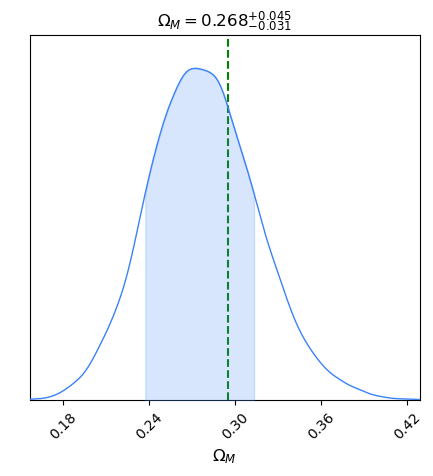

In [479]:
df1 = pd.DataFrame(flat_samples, columns = ['$\Omega_M$'])

#print(df1)
c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="An Example Contour"))
#c.add_chain(flat_samples)
fig = c.plotter.plot()


### Results from paper
omega_m_central = 0.295
omega_m_error_left = 0.043
omega_m_error_right = 0.040
plt.axvline(x=omega_m_central, color="green", linestyle="--", label="Results from paper")
#plt.legend()
print("Results from paper:")
display(Math(r'\Omega_M = 0.295^{{+0.040}}_{{-0.043}}  ') )


### $\Omega_M$ vs $\Omega_\Lambda$ vs $h$

In [493]:
# Define the log prior
def log_prior(theta):
    mu, sigma = theta
    if 0 < sigma < 10:  # Prior for sigma must be positive
        return 0.0  # Flat prior
    return -np.inf  # Reject invalid sigma values

def log_likelihood(theta, data):
    h, omega_m, omega_l = theta
    if h==0:
        return -np.inf
    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    mag_err = data['error_magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)
    
    model1 = distance_modulus(h, z, omega_m, omega_l)
    func_model1 = interp1d(z, model1)
    model2 = func_model1(z_array)
    chi2 = chi_square(model2, mag_array, mag_err)
    chi2 = np.sum(chi2)

    return -chi2/2 

# Define the log posterior (log probability)
def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, data)


In [502]:
data = df

# Number of dimensions (h, omega_m, omega_l)
ndim = 3

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 9

# Initial positions of the walkers (random guesses)
initial_omega_m = np.random.uniform(0.2, 0.4, nwalkers)  # Omega_m
initial_omega_l = np.random.uniform(0.6, 0.8, nwalkers)
initial_h = np.random.uniform(0.65, 0.75, nwalkers)  # Omega_m

pos = np.array([ initial_omega_m, initial_omega_l, initial_h]).T  # Shape (nwalkers, 3)
# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[data])

In [503]:
# Run the MCMC for 500 steps
nsteps = 100000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_16790/1743800503.py:62: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
  0%|          | 0/100000 [00:00<?, ?it/s]/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_16790/1743800503.py:38: RuntimeWarning: invalid value encountered in sqrt
  d_C = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4  )
100%|██████████| 100000/100000 [03:05<00:00, 539.46it/s]


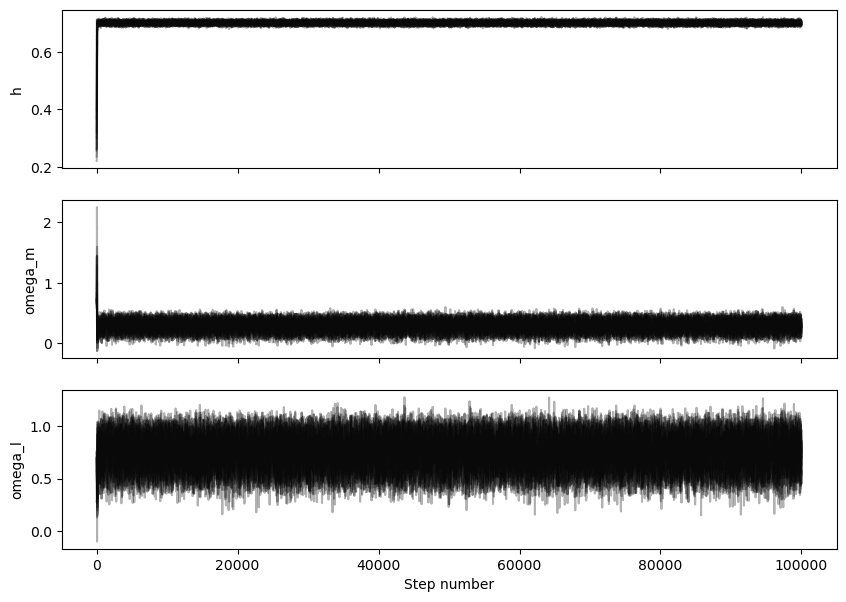

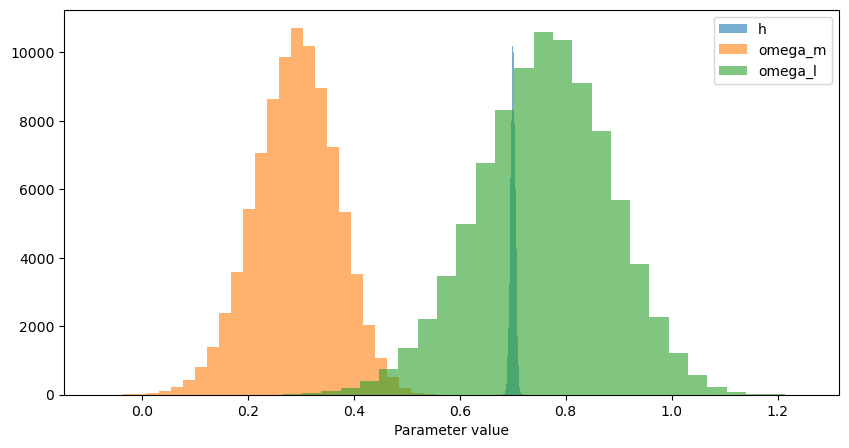

In [504]:
# Plot the walker chains for each parameter
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = [ "h", "omega_m", "omega_l"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.show()

# Flatten the chain (remove burn-in and combine walkers)
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

# Plot histograms of the posterior samples
plt.figure(figsize=(10,5))
plt.hist(flat_samples[:, 0], bins=30, alpha=0.6, label="h")
plt.hist(flat_samples[:, 1], bins=30, alpha=0.6, label="omega_m")
plt.hist(flat_samples[:, 2], bins=30, alpha=0.6, label="omega_l")
plt.xlabel("Parameter value")
plt.legend()
plt.show()

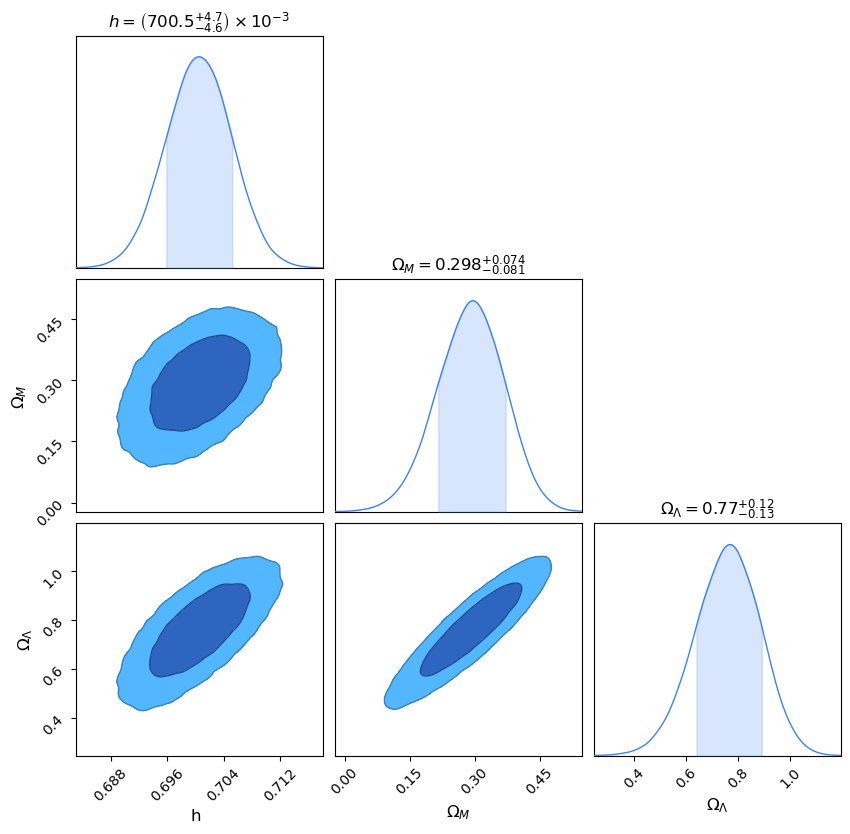

In [505]:
df1 = pd.DataFrame(flat_samples, columns = ['h', '$\Omega_M$', '$\Omega_\Lambda$'])
#print(df1)
c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="An Example Contour"))
#c.add_chain(flat_samples)
fig = c.plotter.plot()

In [506]:
# Calculate the Gelman-Rubin R-hat statistic
r_hat = gelman_rubin(flat_samples)

# Print the R-hat statistic for each parameter
print("Gelman-Rubin R-hat values for each parameter:", r_hat)

Gelman-Rubin R-hat values for each parameter: 0.8549555790562544


In [507]:
### SAVE RESULTS ####

df1.to_csv("h_omega_m_omega_l-curved_universe_EMCEE.csv", index=False)

### $\Omega_M$ vs $\omega$  (Flat wCDM)

In [250]:
# Define the log prior
def log_prior(theta):
    omega_m, w = theta
    if 0.02 < omega_m < 0.535 and -1.75 < w < -0.25:
        return 0
    return -np.inf  # Reject invalid sigma values

def log_likelihood(theta, data):
    omega_m, w = theta

    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    mag_err = data['error_magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)
    
    model1 = distance_modulus(0.7, z, omega_m, 0, 0, w=w)
    func_model1 = interp1d(z, model1)
    model2 = func_model1(z_array)
    chi2 = chi_square(model2, mag_array, mag_err)
    chi2 = np.sum(chi2)
    return -chi2/2 

# Define the log posterior (log probability)
def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_posterior(theta, data)




#### With strict priors

In [251]:
data = df

# Number of dimensions (h, omega_m, omega_l, w)
ndim = 2

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 6

# Initial positions of the walkers (random guesses)
#initial_guesses = np.random.uniform(low=0.1, high=1, size=(nwalkers, ndim))
initial_omega_m = np.random.uniform(0.25, 0.35, nwalkers)  # Omega_m
initial_w = np.random.uniform(-1.5, -0.5, nwalkers)      # w

# Combine initial positions into one array (for 3 parameters)
pos = np.array([ initial_omega_m, initial_w]).T  # Shape (nwalkers, 3)
print(pos)
# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[data])

[[ 0.29802939 -1.36909288]
 [ 0.26863753 -1.20034377]
 [ 0.26671004 -0.7875988 ]
 [ 0.28776494 -1.41078232]
 [ 0.31795328 -0.92978709]
 [ 0.25747994 -0.82499664]]


In [252]:
# Run the MCMC for 500 steps
nsteps = 100000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_16790/3825570453.py:62: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
100%|██████████| 100000/100000 [02:14<00:00, 744.66it/s]


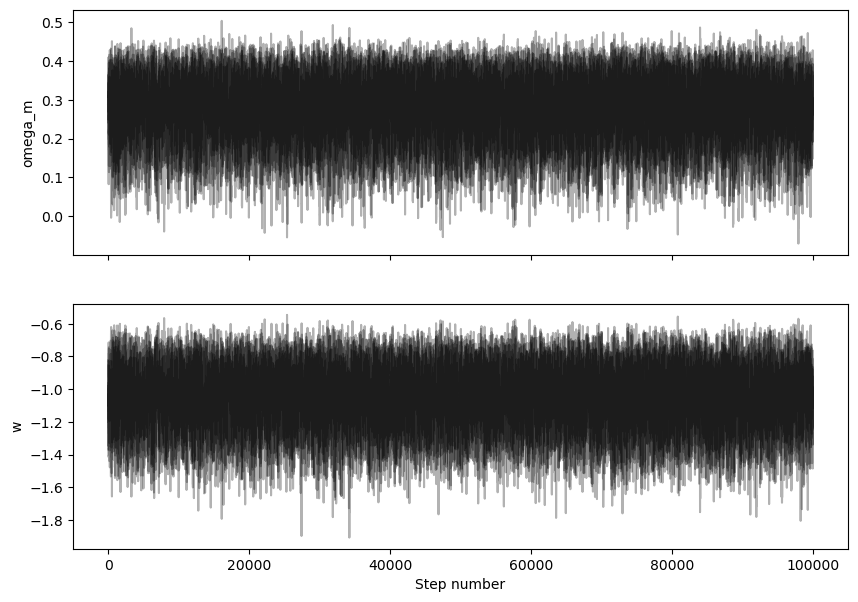

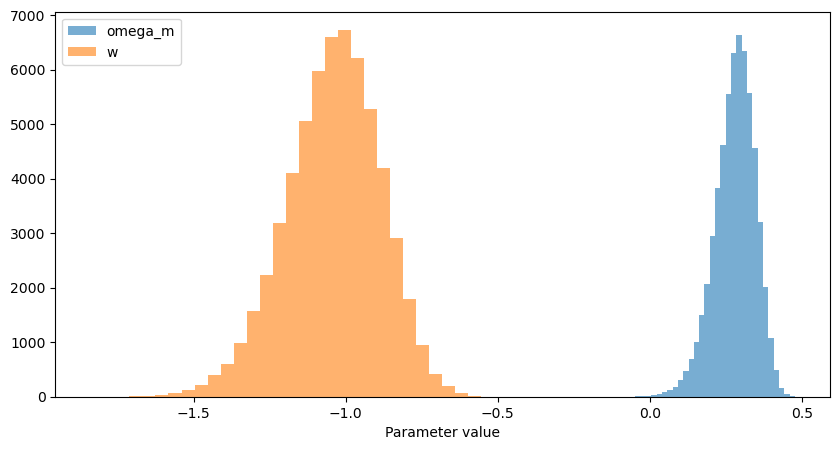

In [253]:
# Plot the walker chains for each parameter
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = [ "omega_m", "w"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.show()

# Flatten the chain (remove burn-in and combine walkers)
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

# Plot histograms of the posterior samples
plt.figure(figsize=(10,5))
plt.hist(flat_samples[:, 0], bins=30, alpha=0.6, label="omega_m")
plt.hist(flat_samples[:, 1], bins=30, alpha=0.6, label="w")

plt.xlabel("Parameter value")
plt.legend()
plt.show()

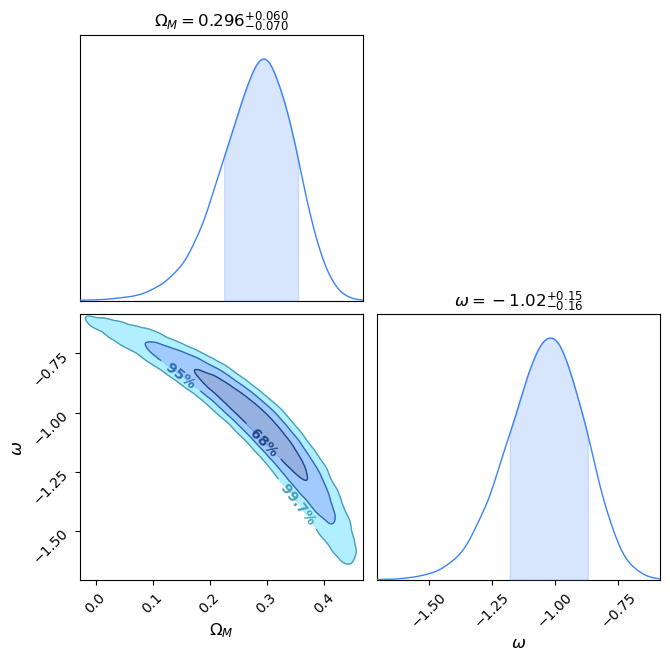

In [254]:
df1 = pd.DataFrame(flat_samples, columns = ['$\Omega_M$', '$\omega$'])
c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="An Example Contour", show_contour_labels=True))
c.set_override(ChainConfig(sigmas=[0, 1, 2, 3]))
#c.add_truth(Truth(location={"A": 0, "B": 5}, color="#500724"))

fig = c.plotter.plot()

In [255]:
### SAVE RESULTS ####

df1.to_csv("w_omega_m-EMCEE_strict_prior.csv", index=False)

#### Using marginalized log likelihood

In [465]:
def log_prior(theta):
    omega_m, w = theta
    if 0.02 < omega_m < 0.535 and -1.75 < w < -0.25:
        return 0
    return -np.inf  # Reject invalid sigma values

def marginalized_log_likelihood(theta, data):
    """ Flat universe """
    omega_m, w = theta

    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    mag_err = data['error_magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)
    #h = np.linspace(0.68, 0.72, 1000)


    # Marginalize over H0
    
    om_k = 0
    om_r = 9.e-5
    om_l = 1 - omega_m - om_r - om_k

    #d_H = 2997.92458/h
    #A = 5 * np.log10(d_H)

    int1 = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : 1/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda * (1 + z)**(3 * (1 + w)) + omega_r * (1+z)**4)
    int1 = cumulative_trapezoid(int1(omega_m, om_l, om_k), z, initial=0)
    func = interp1d(z, int1)
    int1 = func(z_array)

    B = (5 * np.log10((1 + z_array) * int1)) + 25

    f1 = 0.5 * np.sum(1 / (mag_err ** 2))
    f2 = np.sum((B - mag_array) / (mag_err ** 2))
    f3 = 0.5 * np.sum(((B - mag_array) ** 2 )/ (mag_err ** 2))

    chi2_marginalized = (2 * f3) - (f2**2 / (2 * f1))
    
    #integrand = lambda f1, f2, f3, A: np.exp(f3 + (A * f2) + (f1 * A * A))

    marginalized_likelihood = np.exp(-0.5 * chi2_marginalized)#trapezoid(integrand(f1, f2, f3, A), h)    
    return np.log(marginalized_likelihood)

# Define the log posterior (log probability)
def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + marginalized_log_likelihood(theta, data)


data = df

# Number of dimensions (h, omega_m, omega_l, w)
ndim = 2

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 6

# Initial positions of the walkers (random guesses)
#initial_guesses = np.random.uniform(low=0.1, high=1, size=(nwalkers, ndim))
initial_omega_m = np.random.uniform(0.25, 0.35, nwalkers)  # Omega_m
initial_w = np.random.uniform(-1.5, -0.5, nwalkers)      # w

# Combine initial positions into one array (for 3 parameters)
pos = np.array([ initial_omega_m, initial_w]).T  # Shape (nwalkers, 3)
print(pos)
# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])

[[ 0.3084168  -1.12096169]
 [ 0.32865772 -0.77531613]
 [ 0.31093446 -0.62838613]
 [ 0.26248031 -1.18553231]
 [ 0.28410131 -0.91756421]
 [ 0.30939976 -1.19773809]]


In [466]:
# Run the MCMC 
nsteps = 100000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

100%|██████████| 100000/100000 [02:15<00:00, 735.39it/s]


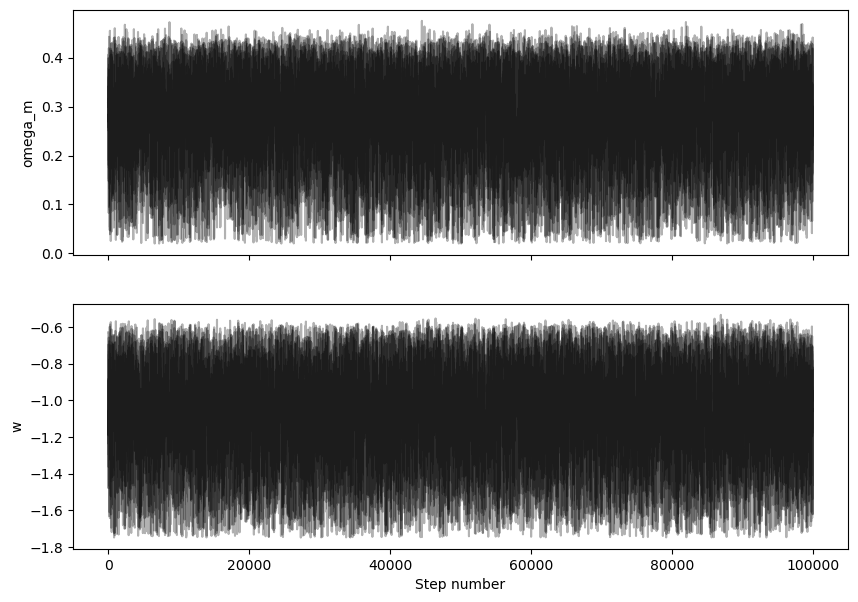

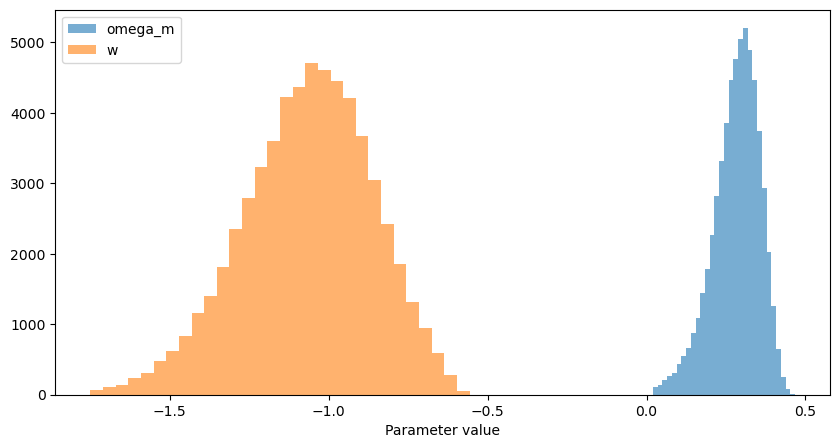

In [467]:
# Plot the walker chains for each parameter
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = [ "omega_m", "w"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.show()

# Flatten the chain (remove burn-in and combine walkers)
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

# Plot histograms of the posterior samples
plt.figure(figsize=(10,5))
plt.hist(flat_samples[:, 0], bins=30, alpha=0.6, label="omega_m")
plt.hist(flat_samples[:, 1], bins=30, alpha=0.6, label="w")

plt.xlabel("Parameter value")
plt.legend()
plt.show()

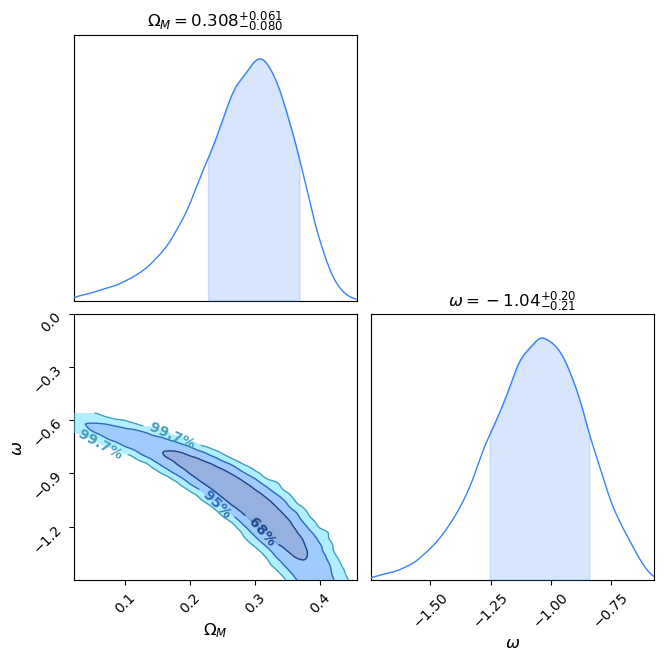

In [468]:
df1 = pd.DataFrame(flat_samples, columns = ['$\Omega_M$', '$\omega$'])
c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="An Example Contour", show_contour_labels=True))
c.set_override(ChainConfig(sigmas=[0, 1, 2, 3]))
c.add_truth(Truth(location={"$\Omega_M$": 0, "$\omega$": 5}, color="#500724"))
#c.plotter.plot(extents={"$\omega$": (-1.5,0.0)})

fig = c.plotter.plot()

# Customize the axis limits using matplotlib's set_xlim and set_ylim
ax = fig.axes[2]  # Access the first subplot
ax.set_ylim(-1.5, 0.0)  # Set limits for the second parameter

# Optional: Save or show the plot
plt.show()

In [489]:
print("Results from paper:")
display(Math(r'\Omega_M = 0.296^{{+0.102}}_{{-0.180}} \\ \omega = -1.001^{{+0.348}}_{{-0.398}}') )

Results from paper:


<IPython.core.display.Math object>

In [469]:
### SAVE RESULTS ####

df1.to_csv("w_omega_m-EMCEE_marginalized.csv", index=False)

#### Marginalized likelihood with covariance matrix

Is this even possible? Yes!

In [480]:
# Define the log prior
def log_prior(theta):
    omega_m, w = theta
    if 0.02 < omega_m < 0.535 and -3.0 < w < -0.25:  
        return 0.0  # Flat prior
    return -np.inf  # Reject invalid sigma values

def marginalized_log_likelihood_covariance(theta, data, inv_cov):
    """ Flat universe """
    omega_m, w = theta

    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    n = mag_array.size
    #mag_err = data['error_magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)
    #h = np.linspace(0.65, 0.75, n) ### prior

    # Marginalize over H0
    
    om_k = 0
    om_r = 9.e-5
    om_l = 1 - omega_m - om_r - om_k

    #d_H = 2997.92458/h
    #A = - 5 * np.log10(h)

    int1 = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : 1/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda * (1 + z)**(3 * (1 + w)) + omega_r * (1+z)**4)
    int1 = cumulative_trapezoid(int1(omega_m, om_l, om_k), z, initial=0)
    func = interp1d(z, int1)
    int1 = func(z_array)

    B = (5 * np.log10((1 + z_array) * int1)) + 25 + (5 * np.log10(2997.92458))

    f1 = np.dot(np.ones_like(mag_array).T, np.dot(inv_cov, np.ones_like(mag_array)))
    f2 = - 2 * np.dot(np.ones_like(mag_array).T, np.dot(inv_cov, (mag_array - B)))
    f3 = np.dot((mag_array - B).T, np.dot(inv_cov, mag_array - B))

    #integrand = lambda f1, f2, f3, A: np.exp(-0.5 * ((f1 * A * A) + (f2 * A) + f3))
    chi2_marginalized = f3 - (f2**2 / (4 * f1))

    marginalized_likelihood = np.exp(- 0.5 * chi2_marginalized) #trapezoid(integrand(f1, f2, f3, A), h)   

    #marginalized_likelihood = np.sqrt((2*np.pi)/f1) * np.exp((f2**2 / (2*f1)) - (f3/2)) # this is integrated wrt A not h
    return np.log(marginalized_likelihood)

# Define the log posterior (log probability)
def log_posterior(theta, data, inv_cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + marginalized_log_likelihood_covariance(theta, data, inv_cov)


In [481]:
data = df

# Number of dimensions (h, omega_m, omega_l, w)
ndim = 2

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 6

# Initial positions of the walkers (random guesses)
#initial_guesses = np.random.uniform(low=0.1, high=1, size=(nwalkers, ndim))
initial_omega_m = np.random.uniform(0.25, 0.35, nwalkers)  # Omega_m
initial_w = np.random.uniform(-1.5, -0.5, nwalkers)      # w

# Combine initial positions into one array (for 3 parameters)
pos = np.array([ initial_omega_m, initial_w]).T  # Shape (nwalkers, 3)
print(pos)
# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data, inv_cov])

[[ 0.31983398 -0.57610071]
 [ 0.34403942 -0.63232692]
 [ 0.25212677 -0.77521838]
 [ 0.31618524 -0.76758898]
 [ 0.26021209 -0.70570111]
 [ 0.3106368  -0.71491836]]


In [482]:
# Run the MCMC for 500 steps
nsteps = 100000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

  0%|          | 12/100000 [00:00<15:14, 109.28it/s]

100%|██████████| 100000/100000 [18:47<00:00, 88.67it/s] 


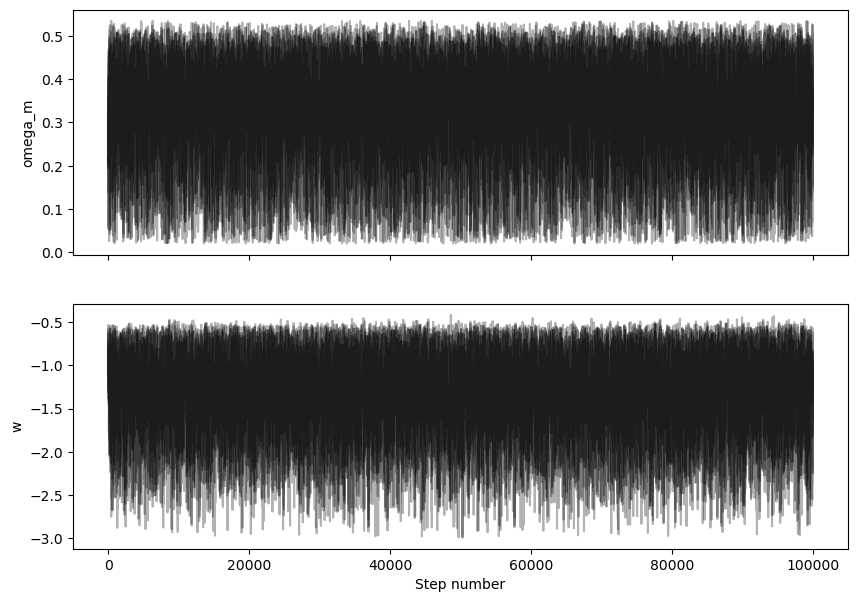

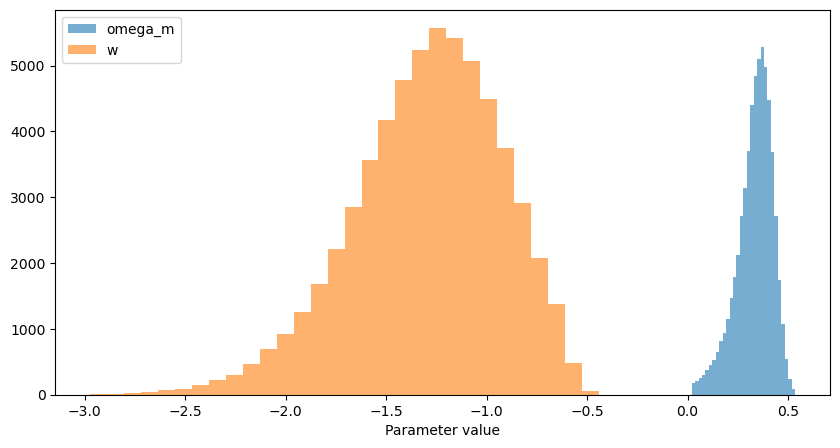

In [483]:
# Plot the walker chains for each parameter
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = [ "omega_m", "w"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.show()

# Flatten the chain (remove burn-in and combine walkers)
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

# Plot histograms of the posterior samples
plt.figure(figsize=(10,5))
plt.hist(flat_samples[:, 0], bins=30, alpha=0.6, label="omega_m")
plt.hist(flat_samples[:, 1], bins=30, alpha=0.6, label="w")

plt.xlabel("Parameter value")
plt.legend()
plt.show()

Results from paper:


<IPython.core.display.Math object>

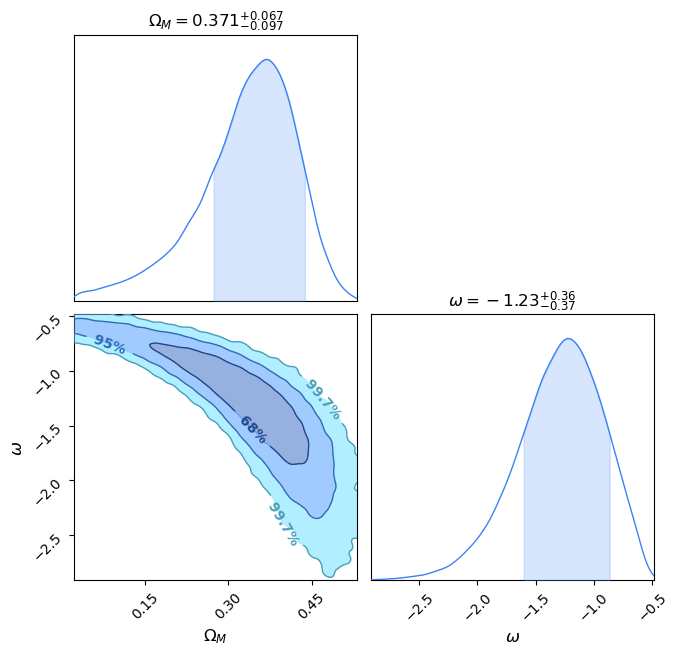

In [487]:
df1 = pd.DataFrame(flat_samples, columns = ['$\Omega_M$', '$\omega$'])
c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="An Example Contour", show_contour_labels=True))
c.set_override(ChainConfig(sigmas=[0, 1, 2, 3]))
c.add_truth(Truth(location={"$\Omega_M$": 0, "$\omega$": 5}, color="#500724"))
#c.plotter.plot(extents={"$\omega$": (-1.5,0.0)})

fig = c.plotter.plot()
'''
# Customize the axis limits using matplotlib's set_xlim and set_ylim
ax = fig.axes[2]  # Access the first subplot
ax.set_ylim(-1.5, 0.0)  # Set limits for the second parameter

# Optional: Save or show the plot
plt.show()'''

### Results from paper
omega_m_central = 0.296
omega_m_error_left = 0.043
omega_m_error_right = 0.040
plt.axvline(x=omega_m_central, color="green", linestyle="--", label="Results from paper")
#plt.legend()
print("Results from paper:")
display(Math(r'\Omega_M = 0.296^{{+0.102}}_{{-0.180}} \\ \omega = -1.001^{{+0.348}}_{{-0.398}}') )

plot paper results on plots

In [488]:
### SAVE RESULTS ####

df1.to_csv("w_omega_m-EMCEE_marginalized_covariance_matrix_systematics.csv", index=False)

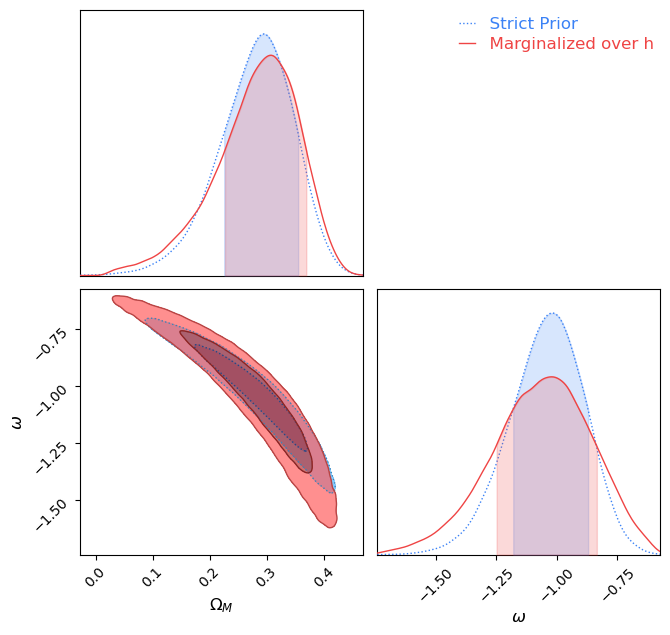

In [276]:
##### COMPARISON OF TWO CASES ABOVE #####

df1 = pd.read_csv("w_omega_m-EMCEE_strict_prior.csv")
df2 = pd.read_csv("w_omega_m-EMCEE_marginalized.csv")

### 2 params

c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="Strict Prior", color = "blue", linestyle=":"))
c.add_chain(Chain(samples=df2, name="Marginalized over h", color = "red"))
fig = c.plotter.plot()


### $\Omega_M$ vs $\Omega_\Lambda$ vs $h$ vs $\omega$

In [370]:
# Define the log prior
def log_prior(theta):
    h, omega_m, omega_l, w = theta
    if 0.65 < h < 0.75 and  0.02 < omega_m < 0.535 and 0.42 < omega_l < 1.05 and -1.5 < w < -0.5:  
        return 0  # Flat prior
    return -np.inf  # Reject invalid parameter values

def log_likelihood(theta, data):
    h, omega_m, omega_l, w = theta

    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    mag_err = data['error_magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)

    model1 = distance_modulus(h, z, omega_m, omega_l, w=w)
    func_model1 = interp1d(z, model1)
    model2 = func_model1(z_array)
    chi2 = chi_square(model2, mag_array, mag_err)
    chi2[np.isnan(chi2)] = np.inf

    chi2 = np.sum(chi2)
    #print(chi2)
    # Add a regularization term to penalize extreme values of omega_lambda and w
    #penalty = 0.01 * (omega_l - 0.7)**2 + 0.01 * (w + 1.0)**2
    
    return -(chi2)/2 

# Define the log posterior (log probability)
def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, data)


In [371]:
data = df

# Number of dimensions (h, omega_m, omega_l, w)
ndim = 4

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 20

# Initial positions of the walkers (random guesses)
#initial_guesses = np.random.uniform(low=0.1, high=1, size=(nwalkers, ndim))
initial_h = np.random.uniform(0.65, 0.75, nwalkers)         # h (Hubble parameter)
initial_omega_m = np.random.uniform(0.25, 0.35, nwalkers)  # Omega_m
initial_omega_l = np.random.uniform(0.68, 0.72, nwalkers)  # Omega_l
initial_w = np.random.uniform(-1.2, -0.8, nwalkers)      # w

# Combine initial positions into one array (for 3 parameters)
pos = np.array([initial_h, initial_omega_m, initial_omega_l, initial_w]).T  # Shape (nwalkers, 3)
print(pos)
# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])

[[ 0.69992704  0.34382877  0.71264031 -1.02098958]
 [ 0.68765822  0.31127633  0.71284584 -1.14246827]
 [ 0.72913938  0.25685734  0.70536213 -1.01181087]
 [ 0.67412462  0.2605101   0.7051239  -0.80504311]
 [ 0.74568783  0.25697643  0.71513041 -1.16825035]
 [ 0.65509369  0.2551634   0.7154301  -1.07752975]
 [ 0.72984734  0.31803955  0.69330291 -0.83779439]
 [ 0.6819539   0.30380311  0.69853672 -0.96025156]
 [ 0.71831726  0.34485886  0.71737929 -1.04659752]
 [ 0.68136778  0.25091421  0.71907159 -1.19093603]
 [ 0.72659325  0.26960896  0.70962909 -0.97513234]
 [ 0.68743127  0.3328894   0.71081333 -0.91783869]
 [ 0.74982501  0.3478697   0.69729704 -1.00640144]
 [ 0.74885955  0.27824919  0.68132207 -1.03886364]
 [ 0.72629015  0.34340465  0.71493108 -1.12580578]
 [ 0.68533562  0.31714661  0.69084259 -0.87142447]
 [ 0.71381154  0.32114332  0.69936595 -0.84082021]
 [ 0.69946698  0.28418981  0.6820255  -1.06063275]
 [ 0.66200022  0.33666157  0.70333944 -1.19079519]
 [ 0.74458269  0.31752961  0.71

In [372]:
# Run the MCMC for 500 steps
nsteps = 100000
sampler.reset()
sampler.run_mcmc(pos, nsteps, progress=True, store=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_16790/200815787.py:62: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [05:48<00:00, 286.97it/s]


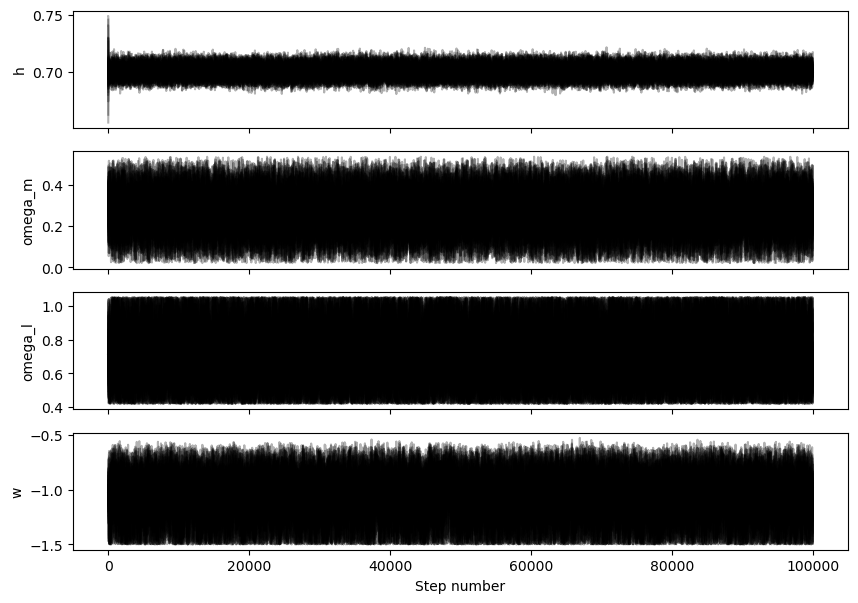

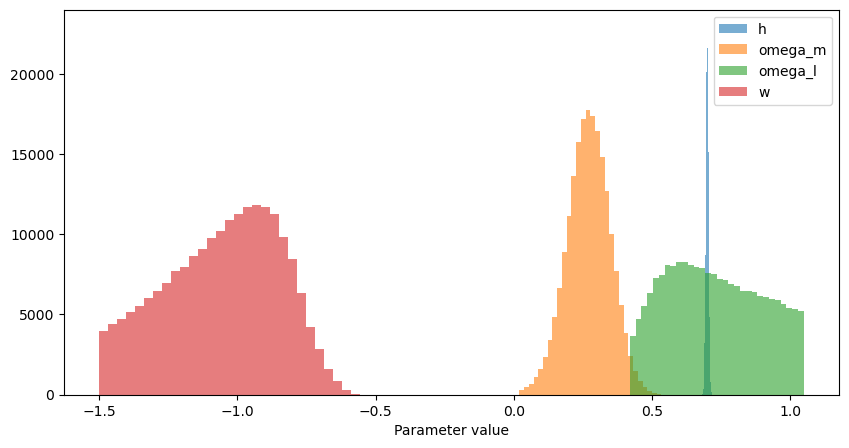

In [373]:
# Plot the walker chains for each parameter
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
labels = [ "h", "omega_m", "omega_l", "w"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.show()

# Flatten the chain (remove burn-in and combine walkers)
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

# Plot histograms of the posterior samples
plt.figure(figsize=(10,5))
plt.hist(flat_samples[:, 0], bins=30, alpha=0.6, label="h")
plt.hist(flat_samples[:, 1], bins=30, alpha=0.6, label="omega_m")
plt.hist(flat_samples[:, 2], bins=30, alpha=0.6, label="omega_l")
plt.hist(flat_samples[:, 3], bins=30, alpha=0.6, label="w")

plt.xlabel("Parameter value")
plt.legend()
plt.show()

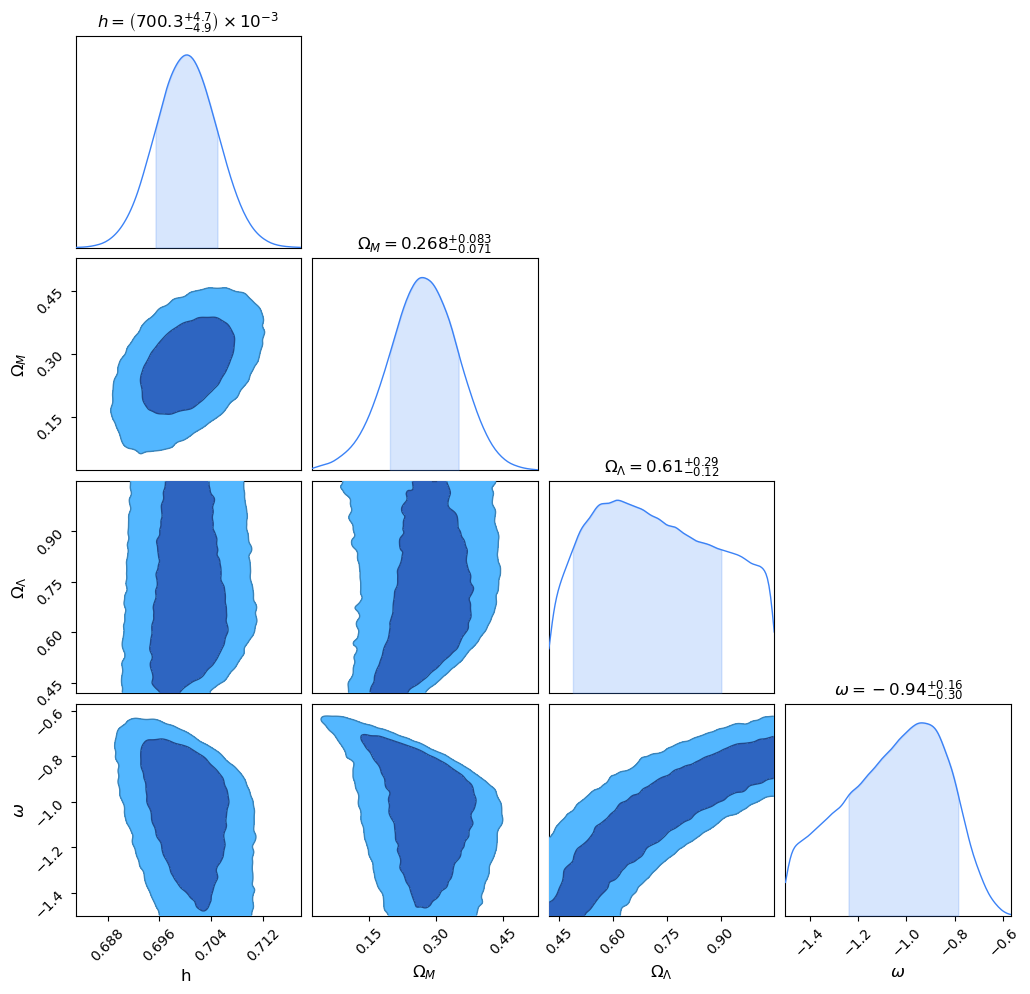

In [374]:
df1 = pd.DataFrame(flat_samples, columns = ['h', '$\Omega_M$', '$\Omega_\Lambda$', '$\omega$'])
#print(df1)
c = ChainConsumer()
om_m_true = 0.281
w_true = -1.007
h_true = 0.7
om_l_true = 0.705
c.add_chain(Chain(samples=df1, name="An Example Contour", truths=[h_true, om_m_true, om_l_true, w_true]))
#c.add_chain(flat_samples)
fig = c.plotter.plot()

In [375]:
# Calculate the Gelman-Rubin R-hat statistic
r_hat = gelman_rubin(flat_samples)

# Print the R-hat statistic for each parameter
print("Gelman-Rubin R-hat values for each parameter:", r_hat)

Gelman-Rubin R-hat values for each parameter: 0.872335150067819


### $\Omega_M$ vs $\Omega_k$ vs $h$ vs $\omega$

In [227]:
def d_L(h, z, o_m, o_k, **kwargs):
    """Calculate Luminosity distance for given cosmological parameters.

    Parameters
    ----------
    h : int or np.array
        hubble parameter 
    z : np.array
        redshift 
    o_m : int
        Omega_m 
    o_l : int
        Omega_Lambda
    o_k : int
        Omega_k
    w : int (optional)
        DE EOS parameter 
        
    Returns
    -------
    d_L : np.array
        Luminosity distance
    """

    o_r = 9.e-5
    o_l = 1 - o_m - o_r - o_k

    w = kwargs.get('w', None)

    # Hubble distance
    d_H = 2997.92458/h
    
    # Comoving Distance
    d_C = lambda omega_m, omega_lambda, omega_k, w, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda * (1 + z)**(3 * (1 + w)) + omega_r * (1+z)**4)
    d_C = cumulative_trapezoid(d_C(o_m, o_l, o_k, w), z, initial=0)
    d_C[np.isnan(d_C)] = 0
    
    # Transverse comoving distance:
    omega_k = o_k
    if omega_k > 0:
        d_M = d_H * (1/np.sqrt(omega_k)) * np.sinh((np.sqrt(omega_k) * d_C) / d_H) 
    if omega_k == 0:
        d_M = d_C
    if omega_k < 0:
        d_M = d_H * (1/np.sqrt(-omega_k)) * np.sin((np.sqrt(-omega_k) * d_C) / d_H) 

    # Luminosity Distance
    d_L = (1 + z) * d_M
    return d_L

def distance_modulus(h, z, omega_m, omega_k, **kwargs):
    """ Calculate distance modulus """
    w = kwargs.get('w', None)
    dl = d_L(h, z, omega_m, omega_k, w=w)
    dis_mod = 5 * np.log10(dl) + 25
    return dis_mod


# Define the log prior
def log_prior(theta):
    h, omega_m, omega_k, w = theta
    if 0.65 < h < 0.75 and  0.02 < omega_m < 0.535 and -0.5 < omega_k < 0.5 and -1.5 < w < -0.5:  
        return 0  # Flat prior

    return -np.inf  # Reject invalid parameter values

def log_likelihood(theta, data):
    h, omega_m, omega_k, w = theta

    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    mag_err = data['error_magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)

    model1 = distance_modulus(h, z, omega_m, omega_k, w=w)
    func_model1 = interp1d(z, model1)
    model2 = func_model1(z_array)
    chi2 = chi_square(model2, mag_array, mag_err)
    chi2[np.isnan(chi2)] = np.inf
    chi2 = np.sum(chi2)    
    return -chi2/2 

# Define the log posterior (log probability)
def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, data)


In [228]:
data = df

# Number of dimensions (h, omega_m, omega_k, w)
ndim = 4

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 20

# Initial positions of the walkers (random guesses)
#initial_guesses = np.random.uniform(low=0.1, high=1, size=(nwalkers, ndim))
initial_h = np.random.uniform(0.65, 0.75, nwalkers)         # h (Hubble parameter)
initial_omega_m = np.random.uniform(0.25, 0.35, nwalkers)  # Omega_m
initial_omega_k = np.random.uniform(-0.5, 0.5, nwalkers)  # Omega_k
initial_w = np.random.uniform(-1.5, -0.5, nwalkers)      # w

# Combine initial positions into one array (for 3 parameters)
pos = np.array([initial_h, initial_omega_m, initial_omega_k, initial_w]).T  # Shape (nwalkers, 3)
print(pos)
# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])

[[ 0.72455443  0.29653035  0.27951206 -0.70456287]
 [ 0.74997105  0.30507997  0.16372255 -0.97827502]
 [ 0.71707681  0.34604726  0.05819479 -1.1303852 ]
 [ 0.71634597  0.27199769  0.47448771 -0.68929432]
 [ 0.73049357  0.25630708 -0.13154669 -1.10984205]
 [ 0.7357447   0.33435816  0.28031401 -1.20417307]
 [ 0.74368306  0.32204683 -0.30075205 -0.59246165]
 [ 0.68234329  0.2877046   0.37091763 -1.19274532]
 [ 0.73835939  0.29547861  0.19375146 -1.18460349]
 [ 0.67780719  0.27178236  0.15023169 -0.97117325]
 [ 0.70867879  0.32136411 -0.22964691 -1.36376283]
 [ 0.69788832  0.31511413 -0.17950224 -1.07115658]
 [ 0.74817712  0.26092103  0.29261792 -1.34459517]
 [ 0.69587587  0.29473946  0.19291308 -1.12656239]
 [ 0.71092842  0.31076889  0.06732242 -1.48034066]
 [ 0.66552529  0.31599075  0.20568912 -1.33961468]
 [ 0.69326401  0.31091487  0.05916275 -1.36693779]
 [ 0.71426225  0.30842654  0.01859994 -1.16067261]
 [ 0.71215742  0.28006206  0.19629195 -1.13578453]
 [ 0.71990749  0.25098092  0.18

In [229]:
# Run the MCMC for 500 steps
nsteps = 100000
sampler.reset()
sampler.run_mcmc(pos, nsteps, progress=True, store=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_16790/2374606123.py:55: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
100%|██████████| 100000/100000 [05:49<00:00, 286.20it/s]


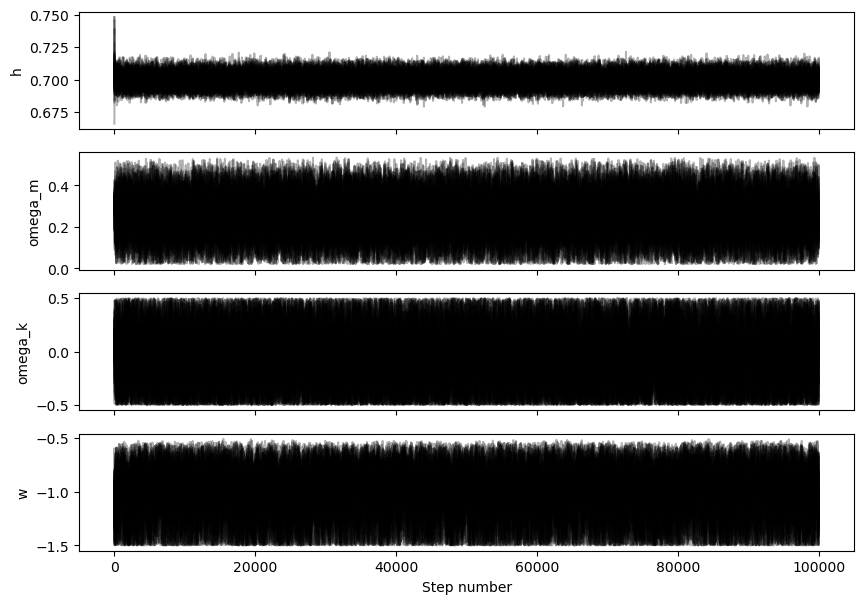

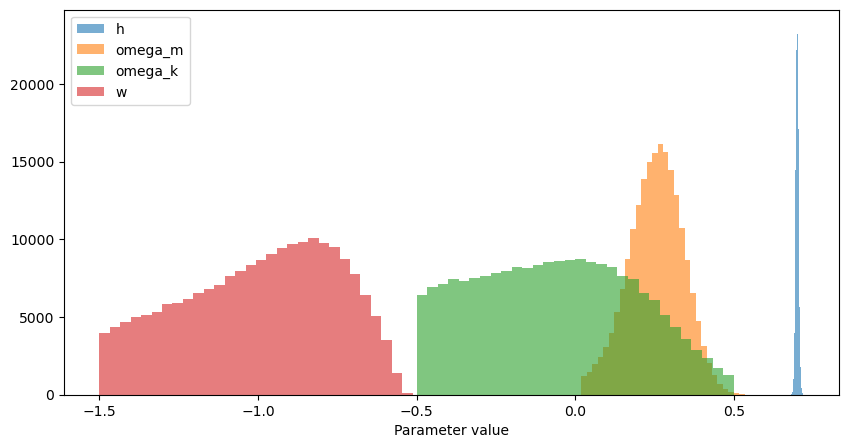

In [230]:
# Plot the walker chains for each parameter
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
labels = [ "h", "omega_m", "omega_k", "w"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.show()

# Flatten the chain (remove burn-in and combine walkers)
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

# Plot histograms of the posterior samples
plt.figure(figsize=(10,5))
plt.hist(flat_samples[:, 0], bins=30, alpha=0.6, label="h")
plt.hist(flat_samples[:, 1], bins=30, alpha=0.6, label="omega_m")
plt.hist(flat_samples[:, 2], bins=30, alpha=0.6, label="omega_k")
plt.hist(flat_samples[:, 3], bins=30, alpha=0.6, label="w")

plt.xlabel("Parameter value")
plt.legend()
plt.show()

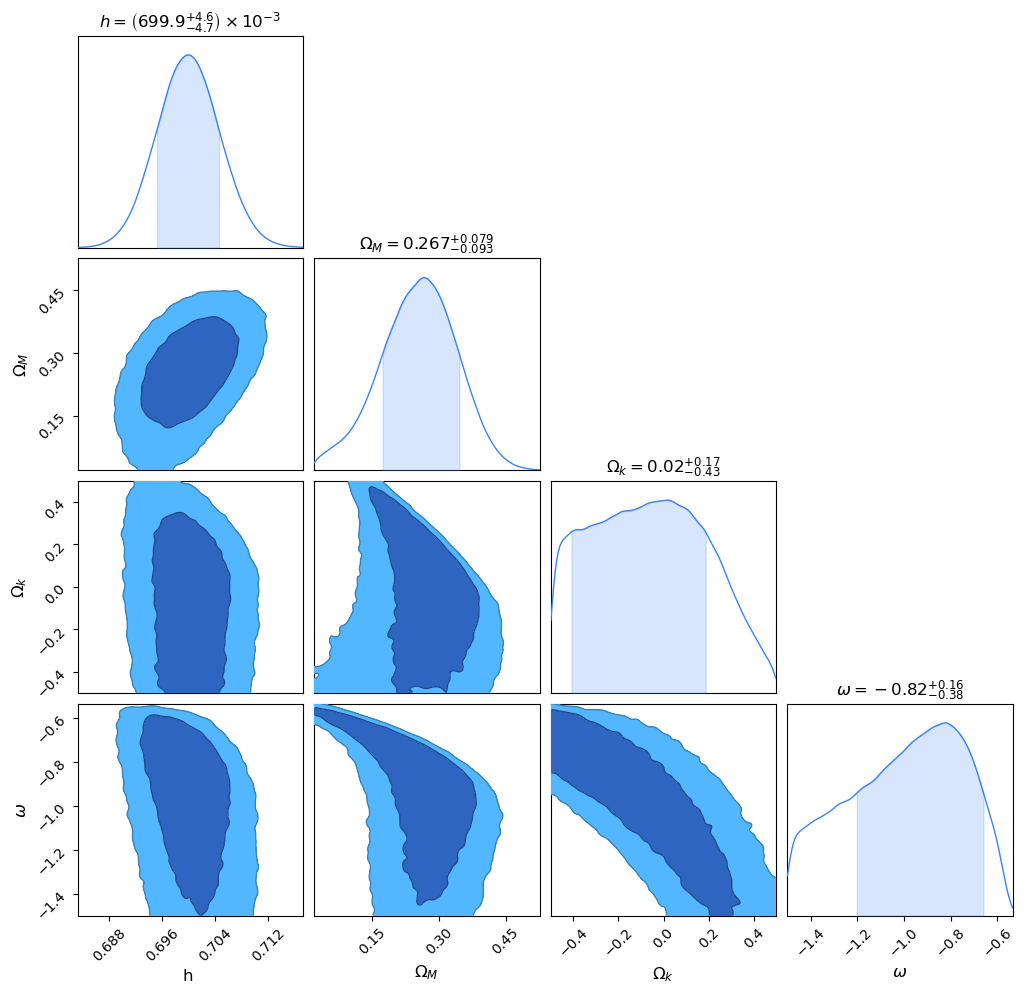

In [231]:
df1 = pd.DataFrame(flat_samples, columns = ['h', '$\Omega_M$', '$\Omega_k$', '$\omega$'])
#print(df1)
c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="An Example Contour"))
#c.add_chain(flat_samples)
fig = c.plotter.plot()